## FT7206 SEMINAR - LSTM
By the end of this activity, learners will be able to set up and apply LSTM in time series forecasting

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import eikon as ek

In [2]:
ek.set_app_key('4a3e5a3b0ff943d68f2a79e37cf828fe4354b99e')

In [3]:
df = ek.get_timeseries('7203.T',
                      fields = "*",
                      start_date = '2010-10-01',
                      end_date  = '2022-11-22')

In [4]:
df.head()

7203.T,HIGH,CLOSE,LOW,OPEN,VOLUME
Date,,,,,
2010-10-01,603.0,596.6,588.2,601.0,46522500
2010-10-04,604.0,592.4,590.0,598.2,39779000
2010-10-05,599.6,595.0,583.4,592.4,45027000
2010-10-06,595.4,590.4,588.2,595.2,46209000
2010-10-07,598.6,590.6,588.4,589.8,43071000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2969 entries, 2010-10-01 to 2022-11-22
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HIGH    2969 non-null   Float64
 1   CLOSE   2969 non-null   Float64
 2   LOW     2969 non-null   Float64
 3   OPEN    2969 non-null   Float64
 4   VOLUME  2969 non-null   Int64  
dtypes: Float64(4), Int64(1)
memory usage: 153.7 KB


In [6]:
 cols = list(df)[1:6]

In [7]:
df_for_training = df[cols].astype(float)

In [8]:
df_for_training.head()

7203.T,CLOSE,LOW,OPEN,VOLUME
Date,,,,
2010-10-01,596.6,588.2,601.0,46522500.0
2010-10-04,592.4,590.0,598.2,39779000.0
2010-10-05,595.0,583.4,592.4,45027000.0
2010-10-06,590.4,588.2,595.2,46209000.0
2010-10-07,590.6,588.4,589.8,43071000.0


<AxesSubplot:xlabel='Date'>

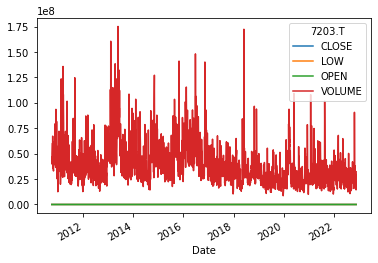

In [9]:
df_for_training.plot.line()

In [10]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [11]:
trainX = []
trainY = []
n_future = 1
n_past = 14

In [12]:
for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    trainX.append(df_for_training_scaled[i -n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i +n_future -1:i + n_future,0])
    
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (2955, 14, 4).
trainY shape == (2955, 1).


In [13]:
model = Sequential()
model.add(LSTM(64, activation='relu',input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
model.add(LSTM(32,activation='relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17664     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
167/167 [==============================] - 2s 8ms/step - loss: 0.0827 - val_loss: 0.0724
Epoch 2/10
167/167 [==============================] - 1s 7ms/step - loss: 0.0277 - val_loss: 0.0615
Epoch 3/10
167/167 [==============================] - 1s 7ms/step - loss: 0.0234 - val_loss: 0.0806
Epoch 4/10
167/167 [==============================] - 1s 7ms/step - loss: 0.0249 - val_loss: 0.0380
Epoch 5/10
167/167 [==============================] - 1s 8ms/step - loss: 0.0241 - val_loss: 0.0885
Epoch 6/10
167/167 [==============================] - 1s 7ms/step - loss: 0.0220 - val_loss: 0.0187
Epoch 7/10
167/167 [==============================] - 1s 7ms/step - loss: 0.0204 - val_loss: 0.0717
Epoch 8/10
167/167 [==============================] - 1s 7ms/step - loss: 0.0207 - val_loss: 0.0234
Epoch 9/10
167/167 [==============================] - 1s 7ms/step - loss: 0.0214 - val_loss: 0.0137
Epoch 10/10
167/167 [==============================] - 1s 7ms/step - loss: 0.0199 - val_loss: 0.0151

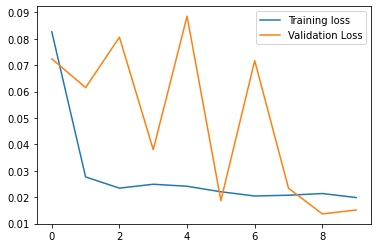

In [15]:
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()

In [16]:
#n_past = 16
#n_days_for_prediction=15  #let us predict past 15 days

In [17]:
train_dates = pd.to_datetime(df.index)

In [18]:
n_future = 365 #redefined forecast period
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

In [19]:
forecast = model.predict(trainX[-n_future:])

12/12 [==============================] - 0s 3ms/step


In [20]:
forecast.shape

(365, 1)

Perform the inverse transformation to rescale back to original range.  
Remember 5 variables went into the original transformation?

In [21]:
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [22]:
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [23]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'OPEN':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='OPEN'>

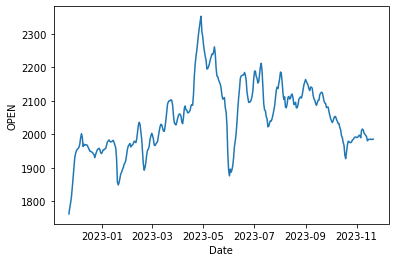

In [24]:
sns.lineplot(df_forecast['Date'],df_forecast['OPEN'])